In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
import json
from langdetect import detect
from deep_translator import GoogleTranslator
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
from tqdm import tqdm
from nltk.corpus import words
import ast
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from os import path
from PIL import Image
nltk.download('words')
nltk.download('stopwords')
pattern = re.compile(r'(,){2,}')
eng_words = set(words.words())
gglt = GoogleTranslator()
pd.set_option("max_rows", 200000)
stop_words = set(stopwords.words('english'))
tqdm.pandas()

[nltk_data] Downloading package words to /home/denis/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/denis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/denis/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
def process_abstract_data():    
    file = open("abstracts.txt","r")
    fw = open("abstracts_processed.txt","w")
    
    # loads the inverted abstracts and stores them as id-abstracts in a dictionary dic 
    dim = 64
    abstract_dict = {}
    for inverted_abstract in file:

        if(inverted_abstract=="\n"):
            continue
        author_id = inverted_abstract.split("----")[0]
        inv = "".join(inverted_abstract.split("----")[1:])
        
        res = ast.literal_eval(inv) 
        abstract =[ "" for i in range(res["IndexLength"])]
        inv_indx=  res["InvertedIndex"]

        for i in inv_indx:
            i_ = i.replace(',','')
            if i_.isalpha():
                for j in inv_indx[i] and i_ not in stop_words:
#                     print(i)
                    abstract[j] = i.lower()
        
        abstract = re.sub(pattern, ',', ",".join(abstract))
       
        fw.write(author_id+"----"+abstract+"\n")
        abstract_dict[author_id] = abstract
    
    fw.close()


In [2]:
def convertAbstract_to_json():
    print("Convert to json function run")
    '''
    Json is lightweight and making this conversion provides just with a lightweight version of the abstracts
    for further preprocesing

    '''

    f = open("abstracts_processed.txt", "r")
    dic = {}
    for l in tqdm(f):
        splitted = l.split("----")
        if len(splitted) < 2:
            continue
        author_id, abstract = splitted
        
        dic[author_id] = abstract
    f.close()

    json.dump(dic, open("abstract_in_json.json", "w"))
    
convertAbstract_to_json()

Convert to json function run


1056540it [00:06, 175981.48it/s]


In [5]:
def remove_stopwords(joined_abstract):
    return " ".join(word for word in joined_abstract.split(",") if word not in stop_words)

In [6]:
def remove_stop_words():
    print("Removing stop words started")
    
    abstract_papers= json.load(open("abstract_in_json.json"))
    abstract_papers =pd.DataFrame( abstract_papers.items(),columns=["paper_id", "abstract"])
    abstract_papers["abstract"] =abstract_papers["abstract"].progress_apply(remove_stopwords)
    
    abstract_papers.to_json("abstract_in_json_no_stopword.json")
remove_stop_words()

Removing stop words started


100%|██████████████████████████████████████████████████████████████████████████████████████| 1056539/1056539 [00:15<00:00, 67374.02it/s]


In [15]:
def proportion_foreign_words(row):
    words = set(row.split(","))
    return len(words.intersection(eng_words)) / len(words)

In [16]:
def detect_lang(row):
    if row == "":
        return "en"
    try:
        return detect(row)
    except:
        return "en"


Segregation run started


100%|████████████████████████████████████████████████████████████████████████████████████████████| 17792/17792 [02:01<00:00, 146.38it/s]
/home/denis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(4655, 4)
(13137, 4)


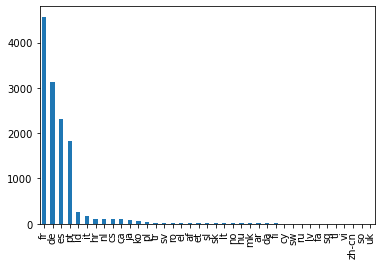

In [19]:
def segregate_abstracts():
    print("Segregation run started")
    threshold_foreign = "0.5"
    abstract_papers= json.load(open("abstract_in_json_no_stopword.json"))
    abstract_papers=pd.DataFrame(abstract_papers.items(), columns=["paper_id", "abstract"])    
    abstract_papers["prop_foreign_word"] = abstract_papers["abstract"].progress_apply(proportion_foreign_words)
    english_abstracts= abstract_papers.query(f"prop_foreign_word > {threshold_foreign}")
    foreign_abstracts = abstract_papers.query(f"prop_foreign_word <= {threshold_foreign}")
    foreign_abstracts["lang"] = foreign_abstracts["abstract"].progress_apply(detect_lang)
    correct_foreign_abstract = foreign_abstracts.query("lang != 'en'")
    incorrect_foreign_abstract = foreign_abstracts.query("lang == 'en'")
    print(incorrect_foreign_abstract.shape)
    english_words_concat = pd.concat([english_abstracts,incorrect_foreign_abstract])
    del english_words_concat["lang"]
    del english_words_concat["prop_foreign_word"]
    print(correct_foreign_abstract.shape)
    
    
    english_words_concat.to_csv("english_abstracts.csv")
    correct_foreign_abstract.to_csv("non_english_abstracts.csv")
  
    correct_foreign_abstract['lang'].value_counts().plot.bar()
segregate_abstracts()


In [25]:
def language_translate(x):
    try:
        return gglt.translate(x)
    except:
        return x

In [26]:

def translate_abstract_to_english():
    print("Translate run started")
    abstract_papers_in_foreign_languges = pd.read_csv("non_english_abstracts.csv")
    abstract_papers_in_foreign_languges["abstract"] = abstract_papers_in_foreign_languges["abstract"].progress_apply(language_translate)
      
    abstract_papers_in_foreign_languges.to_csv("non_english_abstract_translated.csv",encoding="utf8")

translate_abstract_to_english()

Translate run started


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 13137/13137 [29:26<00:00,  7.44it/s]


In [28]:
def further_pre_process_abstract():
  
    translated_abstracts = pd.read_csv("non_english_abstract_translated.csv",encoding="utf8",index_col=False)
    
    english_abstracts =pd.read_csv("english_abstracts.csv",encoding="utf8",index_col=False)
    english_abstracts= english_abstracts[['paper_id', 'abstract']]
    #Drop unwanted indexed
    english_abstracts.drop(english_abstracts.head(1).index, inplace=True)
    translated_abstracts.drop(translated_abstracts.head(1).index, inplace=True)
    translated_abstracts= translated_abstracts[['paper_id',"abstract"]]
    #concatenate the two dataframes into one
    overall_words = pd.concat([english_abstracts, translated_abstracts])
    
    overall_words['paper_id']=overall_words['paper_id'].astype("int64")
    
    #Save file as csv
    overall_words.to_csv("all_abstract_in_english.csv",encoding="utf8",index=False)    
    
    
 
    

In [29]:
further_pre_process_abstract()

In [ ]:
import pandas as pd
import csv
def visualise_common_words():
    '''
    Count the number of non_stop words in each of the abstracts
    '''
    

    reader = csv.DictReader(open('all_abstract_in_english.csv'))
    all_abstract_text=[]
    for row in reader:
        k=row['paper_id']
        v=row['abstract']        
        abstract_text=["".join(x) for x in v.split(",") if x not in stop_words and x!="\n" ]
        all_abstract_text.append(" ".join(abstract_text))      


   
        # print(all_abstract_text)
    text = str(all_abstract_text).strip('[]')

    return text
   

words= visualise_common_words()
wordcloud = WordCloud().generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [2]:
import csv

reader = csv.DictReader(open('all_abstract_in_english.csv'))
abstract_dict={}
for row in reader:
    k=row['paper_id']
    v=row['abstract']
    abstract_dict[k] = v
    

    
    
def generate_abstract_embeddings(abstract_dict):
    print("Running now")
    #Clean the abstract and remove stop words
    doc = []
    for i in abstract_dict:
#         print(i)
        p = abstract_dict[i].split(",")
        abstract_dict[i] = [l for l in p if l.replace(",","").isalpha() and l not in stop_words]
        doc.append(abstract_dict[i])

    # learns the embeddings of each abstract 
    tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(doc)]
    del doc
    model = Doc2Vec(tagged_data, vector_size = 64, window = 5, min_count = 2, epochs = 10, workers=4)

    # store the embeddings in "paperID":array format
    f = open("paper_embeddings_64.txt","w")
    for tid in abstract_dict:
        sentence = abstract_dict[tid]
        f.write(str(tid)+":"+np.array2string(model.infer_vector(sentence), formatter={'float_kind':lambda x: "%.8f" % x})+"\n")    
    f.close()
generate_abstract_embeddings(abstract_dict)

    

Running now
